# **LAB 11 Case studies on Siamese networks**


## Importing Packages

In [3]:
import os
from imutils import build_montages
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Conv2D, Dropout, GlobalAveragePooling2D, MaxPooling2D
import tensorflow.keras.backend as K

## Making The Data

### Making Image Pairs

In [4]:
def make_pairs(images, labels):
	pairImages = []
	pairLabels = []
  
  # Seeing The Number of Unique Labels in Dataset
	numClasses = len(np.unique(labels))
 
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

  # Going Through All The Images
	for idxA in range(len(images)):
		# Getting One Image
		currentImage = images[idxA]
		label = labels[idxA]
		
    # Random Another Image of Same Class
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		# Making A positive Pair, and saving Label, i.e. Same Image & Label = 0
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
  	
    # Random Image of Another Class
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		
    # Making A negative Pair, and saving Label, i.e. Different Image & Label = 1
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	
	return (np.array(pairImages), np.array(pairLabels))

### Performing on MNIST

In [5]:
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# build the positive and negative image pairs
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

images = []
print(pairTrain.shape)

11493376/11490434 [==============================] - 0s 0us/step
(120000, 2, 28, 28)


### Checking One Of The Pairs

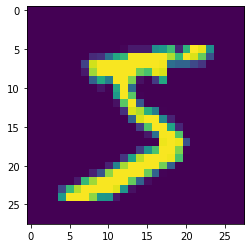

In [6]:
plt.imshow(pairTrain[0, 0])

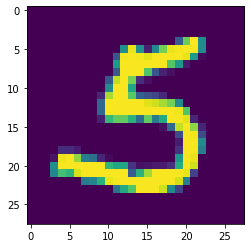

In [7]:
plt.imshow(pairTrain[0, 1])

### For Ease of Visualizations

In [8]:
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
	imageA = pairTrain[i][0]
	imageB = pairTrain[i][1]
	label = labelTrain[i]
	
	output = np.zeros((36, 60), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[4:32, 0:56] = pair
	
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
	
	vis = cv2.merge([output] * 3)
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)

	images.append(vis)

### Display +ve and -ve pairs

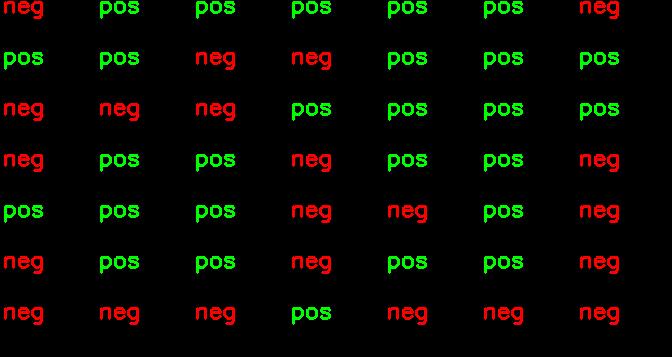

-1

In [9]:
montage = build_montages(images, (96, 51), (7, 7))[0]

cv2_imshow(montage)
cv2.waitKey(0)

## Model Building

### Specifying Important Model Parameters

In [10]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 100
BASE_OUTPUT = "output"

# Path To Model
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])

# Path To Model Plot
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

#Build siamese model 

In [11]:
def build_siamese_model(inputShape, embeddingDim = 48):
	inputs = Input(inputShape)
	
  # First Layer
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
 
	# Second Layer
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 
 	# Making The Final Outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	
  # Making The Model
	model = Model(inputs, outputs)

	return model

### Finding Euclidean Distance Between Scores

In [12]:
def euclidean_distance(vectors):
	(featsA, featsB) = vectors

	sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)

	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

### Plotting Our Data

In [13]:
def plot_training(H, plotPath):
	plt.style.use("ggplot")
	plt.figure()
 
  # Losses
	plt.plot(H.history["loss"], label = "Training Loss")
	plt.plot(H.history["val_loss"], label = "Validation Loss")
 
  # Accuracyis
	plt.plot(H.history["accuracy"], label = "Training Accuracy")
	plt.plot(H.history["val_accuracy"], label = "Validation Loss")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch No.")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc = "lower left")
	plt.savefig(plotPath)

### Building Siamese Network

In [14]:
# Defining The Input
imgA = Input(shape = IMG_SHAPE)
imgB = Input(shape = IMG_SHAPE)

# Making The Model
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [15]:
# Implementing The Euclidean Distance
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation = "sigmoid")(distance)

# Final Model
model = Model(inputs = [imgA, imgB], outputs = outputs)

### Compiling The Model And Running It

In [16]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], 
                    validation_data = ([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size = BATCH_SIZE, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 42s 6ms/step - loss: 0.6937 - accuracy: 0.4924 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6933 - val_accuracy: 0.4474
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4841
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 7/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_ac

### Saving The Model and Plotting The History

INFO:tensorflow:Assets written to: output/siamese_model/assets


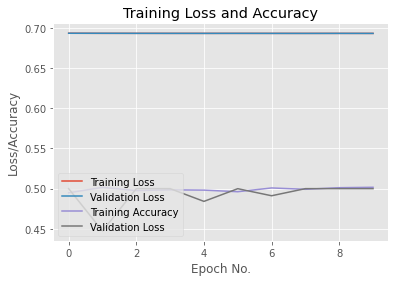

In [17]:
model.save(MODEL_PATH)
plot_training(history, PLOT_PATH)

## Testing Our Model


In [18]:
# Same Pre-Processing As Our Images
imageA = np.expand_dims(pairTest[45, 0], axis = -1)
imageB = np.expand_dims(pairTest[45, 0], axis = -1)

imageA = np.expand_dims(imageA, axis = 0)
imageB = np.expand_dims(imageB, axis = 0)
preds = model.predict([imageA, imageB])

print('The Predicted Accuracy is:', preds[0][0] * 100)

The Predicted Accuracy is: 50.232917070388794


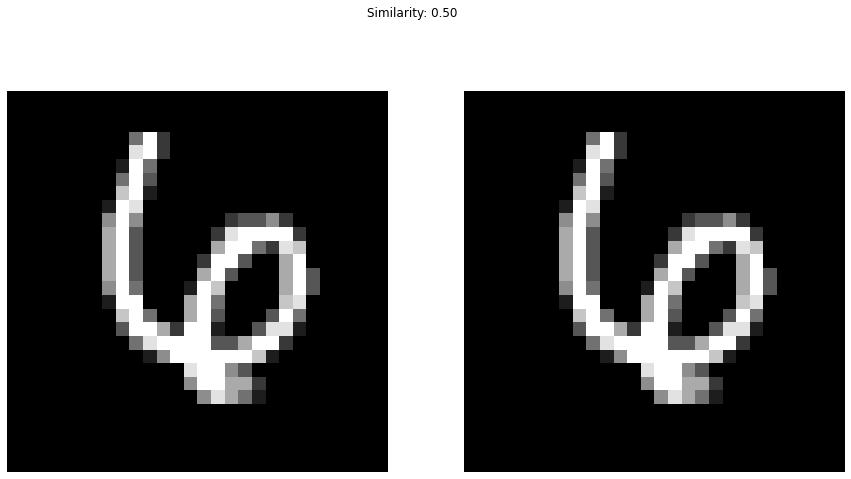

In [19]:
imageA = np.resize(imageA, (28, 28))
imageB = np.resize(imageB, (28, 28))

fig = plt.figure("Pair #{}".format(i + 1), figsize = (15, 8))
plt.suptitle("Similarity: {:.2f}".format(preds[0][0]))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(imageA, cmap = plt.cm.gray)
plt.axis("off") 

ax = fig.add_subplot(1, 2, 2)
plt.imshow(imageB, cmap = plt.cm.gray)
plt.axis("off")

plt.show()